In [1]:
# Library for common functions
# Kedar Patki

# TODO:
#https://www.spectralpython.net/class_func_ref.html
#-----------------------------------------------------------------------------------------
from spectral import *
import numpy as np
import spectral.io.envi as envi
import matplotlib.pyplot as plt
# import pdb
#warnings.filterwarnings('ignore')



#-----------------------------------------------------------------------------------------
def open_envi_image( data_dir, basename ):
    hsi_hdr_file = data_dir + '/' + '{}.img.hdr'.format( basename )
    hsi_img_file = data_dir + '/' + '{}.img'.format( basename )
    img_envi = envi.open( hsi_hdr_file, hsi_img_file )
    img = img_envi.load()
    return img

def open_envi_gt_image( data_dir, basename ):
    hsi_hdr_file = data_dir + '/' + '{}.img.hdr'.format( basename )
    hsi_img_file = data_dir + '/' + '{}.img'.format( basename )
    img_envi = envi.open( hsi_hdr_file, hsi_img_file )
    img = img_envi.load()
    header_file = envi.read_envi_header(hsi_hdr_file)
    print(header_file)
    #print(header_file['bands'])
    return img,header_file



#img2=open_image(hsi_hdr_file).read_band(7)

def wavelength( data_dir, basename ):
    hsi_hdr_file = data_dir + '/' + '{}.img.hdr'.format( basename )
    hsi_img_file = data_dir + '/' + '{}.img'.format( basename )
    img_envi = envi.open( hsi_hdr_file, hsi_img_file )
    wavelength= img_envi.bands.centers
    bands=img_envi.bands
    return wavelength

def view_hsi_image_color(hsi_img):
    hsi_img_b=hsi_img[:,:,14]
    hsi_img_b_normalized=hsi_img_b/np.max(hsi_img_b)
    
    hsi_img_g=hsi_img[:,:,30]
    hsi_img_g_normalized=hsi_img_g/np.max(hsi_img_g)
    
    hsi_img_r=hsi_img[:,:,48]
    hsi_img_r_normalized=hsi_img_r/np.max(hsi_img_r)   
    
    image=np.asarray(255*np.concatenate([hsi_img_b_normalized,
                                         hsi_img_g_normalized,
                                         hsi_img_r_normalized],axis=2),dtype=np.uint8)
    plt.imshow(image)
    plt.show()
    return image


def get_reflectance_image( input_radiance_img,img_with_cal_panel ):
    
    # Get ground-truth reflectance data
    # gt_reflectance_vec_calpanel_80 = 0.80 * np.ones( 224 )
    # gt_reflectance_vec_calpanel_20 = 0.20 * np.ones( 224 )


    # Interpolate and find ground-truth reflectance values at wavelengths of the hsi cube
    # hsi_wavelength_vec = np.array( input_radiance_img.bands.centers )

    # Manually selected cal panel pixels for 2 cal panels at 80% and 20% 
    r1_calpanel_80, c1_calpanel_80 = 406, 595
    r2_calpanel_80, c2_calpanel_80 = 408, 590


    r1_calpanel_20, c1_calpanel_20 = 431, 105
    r2_calpanel_20, c2_calpanel_20 = 436, 107

    # Compute average of the pixels i.e. radiance vectors for each panel
    avg_calpanel_80_radiance_vec = ( img_with_cal_panel[r1_calpanel_80,c1_calpanel_80,:] + 
                                    img_with_cal_panel[r2_calpanel_80,c2_calpanel_80,:] ) / 2
    
    avg_calpanel_20_radiance_vec = ( img_with_cal_panel[r1_calpanel_20,c1_calpanel_20,:] + 
                                    img_with_cal_panel[r2_calpanel_20,c2_calpanel_20,:] ) / 2

    # Compute gain and offset ( a and b ) vectors
    # R=radiance, r=reflectance
    # using R = a*r + b per wavelength, and r = ( R - b ) / a
    # so, a = (R2-R1) / (r2-r1), b = (R1*r2 - R2*r1) / (r2-r1)
    a_vec = ( avg_calpanel_80_radiance_vec - avg_calpanel_20_radiance_vec ) / ( 0.8 - 0.2 )
    b_vec = ( avg_calpanel_20_radiance_vec * 0.8 - avg_calpanel_80_radiance_vec * 0.2 ) / ( 0.8 - 0.2 )

    # Create compensated hsi image i.e. reflectance image
    # reflectance_img_compensated = ( radiance_img - b_vec ) / a_vec
    reflectance_img = ( input_radiance_img - b_vec ) / a_vec

    # save image
    # envi.save_image( '../generated_images/{}_refl.img.hdr'.format( rootname ), reflectance_img )
    return reflectance_img



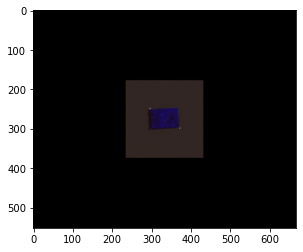

<ipython-input-1-4e528f3810dc>:98: RuntimeWarning: invalid value encountered in divide
  reflectance_img = ( input_radiance_img - b_vec ) / a_vec
C:\Users\Manis\anaconda3\lib\site-packages\spectral\io\spyfile.py:226: NaNValueWarning: Image data contains NaN values.
  warnings.warn('Image data contains NaN values.', NaNValueWarning)


{'description': "Truth data generated by DIRSIG 2023.17 (dcdf40d) 'BasicPlatform' plugin", 'samples': '667', 'lines': '552', 'bands': '9', 'header offset': '0', 'data type': '5', 'interleave': 'BIP', 'byte order': '0', 'band names': ['X Hit Coordinate [m]', 'Y Hit Coordinate [m]', 'Z Hit Coordinate [m]', 'Distance [m]', 'View Angle Cosine []', 'U Texture Coordinate []', 'V Texture Coordinate []', 'Dominant Material Index', 'Dominant Optical Property Index']}


Text(0.5, 1.0, 'Ground Truth')

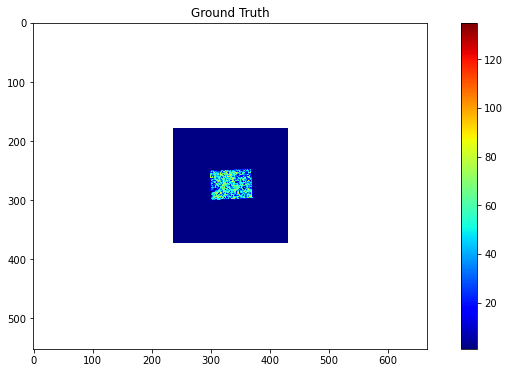

In [2]:
#%%-------------------------------------------------------------------------------
data_dir="F:/HarvardForestV3/1.5m_GSD"
basename='aviris'
img_with_cal_panel=open_envi_image(data_dir,basename)

data_dir="F:/HarvardForestV3/10m_GSD"
basename='aviris'
img_rad=open_envi_image(data_dir,basename)

view_hsi_image_color(img_rad)

img_ref=get_reflectance_image(img_rad,img_with_cal_panel)
wl=wavelength(data_dir,basename)


#########################################################################
#%% Ground Truth Labelled Image
data_dir="F:/HarvardForestV3/10m_GSD"
basename='aviris_truth'
#you can read the header into a Dictionary and then access the bands:
    #https://docs.python.org/3/tutorial/datastructures.html#dictionaries
    
truth_img,header_file=open_envi_gt_image(data_dir,basename)


from spectral import*
Labelled_data=truth_img.read_bands(7)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.axes_style('whitegrid')
fig = plt.figure(figsize=(12, 6))

#q = np.random.randint(data.shape[2])
q=7
plt.imshow(Labelled_data, cmap='jet')
plt.colorbar()
#plt.axis('off')
plt.title('Ground Truth') 

Text(0.5, 1.0, 'band - 7')

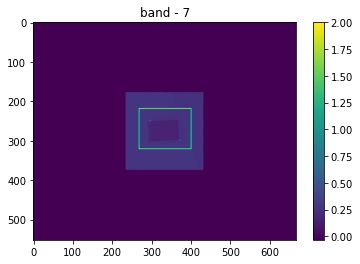

In [3]:
#%%
def extract_rois(arr, x, y, w, h, intensity, line):
    roi = arr[y:y+h, x:x+w, :]

    bounding_box = arr
    bounding_box[y-line:y, x-line:x+w+line, :] = intensity # top line
    bounding_box[y:y+h, x-line:x, :] = intensity # left line
    bounding_box[y+h:y+h+line, x-line:x+w+line, :] = intensity # bottom line
    bounding_box[y:y+h, x+w:x+w+line, :] = intensity # right line

    return (roi, bounding_box)



coordinates = [
    (270, 220) #(x=horizontal,y=vertical)
]

rois = [] # returned ROIs
width = 130 # width and height
height = 100 # width and height
line = 2 # bounding box line width
intensity = 2 # bounding box line intensity
image_bboxed = None


#extract roi for test image
for coordinate in coordinates:
    (x, y) = coordinate
    (roi, image_bboxed) = extract_rois(
        img_ref, x, y, width, height, intensity, line)
    rois.append(roi)


# imshow(image_bboxed, (100, 100, 5))
# imshow(image_bboxed[:, :, 5])


sns.axes_style('whitegrid')
#fig = plt.figure(figsize=(12, 6))

#q = np.random.randint(data.shape[2])
q=7
plt.imshow(image_bboxed[:, :, q])
plt.colorbar()
#plt.axis('off')
plt.title(f'band - {q}')



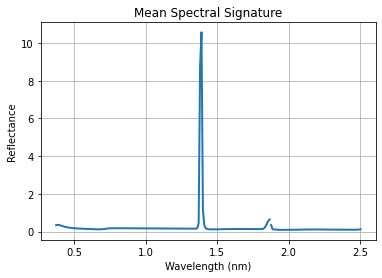

In [4]:

for i in range(len(rois)):
    roi = rois[i]
    intensity = []
    for b in range(roi.shape[2]):
        intensity.append(np.mean(roi[:, :, b]))
    #plt.plot(wl, intensity, label='ROI {}'.format(i+1))
    plt.plot(wl, intensity,linewidth=2)

#plt.legend(loc='upper left')
#plt.title('Spectral Footprint\n Mean in ROI Area')
#plt.rcParams.update({'font.size': 16})
plt.title('Mean Spectral Signature')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid()
plt.savefig('Mean Spectral Signature.png', dpi=200)
plt.show()

Text(0.5, 1.0, 'band - 7')

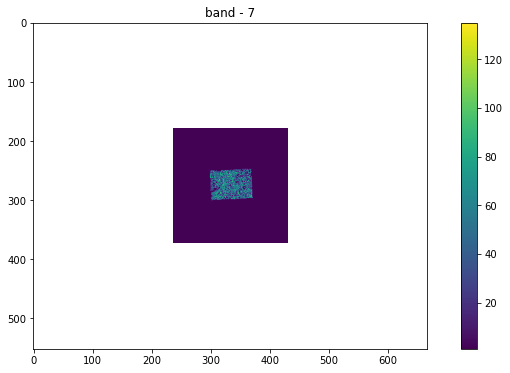

In [5]:
#%%
#extract same roi for ground truth image
rois_gt = [] # returned ROIs
width = 130 # width and height
height = 100 # width and height
line = 2 # bounding box line width
intensity = 2 # bounding box line intensity
image_bboxed = None


for coordinate in coordinates:
    (x, y) = coordinate
    (roi_gt, image_bboxed) = extract_rois(
        truth_img, x, y, width, height, intensity, line)
    rois_gt.append(roi_gt)
    
from spectral import*
Labelled_data_roi=roi_gt.read_bands(7)    
    
# imshow(image_bboxed, (100, 100, 5))
# imshow(image_bboxed[:, :, 5])

sns.axes_style('whitegrid')
fig = plt.figure(figsize=(12, 6))

#q = np.random.randint(data.shape[2])
q=7
plt.imshow(image_bboxed[:, :, q])
plt.colorbar()
#plt.axis('off')
plt.title(f'band - {q}')


In [6]:
#%% combining 'acerpe':[82,9,81,63,53],'acerru':[34,40,71,45,39,70] into acer
#    'betual':[133,77,64,88,22],'betule':[113,93,68,27,42],'betupa':[89],'betupo':[47,121,119,78] into betu
#    'pinure':[37,104,110,15],'pinust':[131,102,28,76,46,33], into pinu
#    'queral':[69,36,120,16,49,25],'querru':[67,112,92,61,5,83,26,80,66,8,79,7], into quer
    
speciesToID = {
    'acer':[82,9,81,63,53,34,40,71,45,39,70],
    'aronme':[54,98,132,108],
    'bark':[65,62,117,135],
    'betu':[133,77,64,88,22,113,93,68,27,42,89,47,121,119,78],
    'castde':[116,14,115,51,50],
    'dead':[17,59,38,60,35,130],
    'fagugr':[123,72,57,96,18],
    'fraxni':[122],
    'hamavi':[74,12,85,55,75],
    'ilexve':[32,73,95,107,56],
    'kalmla':[20],
    'larila':[84],
    'lyonli':[127,124,105,129,126],
    'nemomu':[21,13,86,29,118],
    'nysssy':[6],
    'ostrvi':[94],
    'piceab':[114],
    'pinu':[37,104,110,15,131,102,28,76,46,33],
    'quer':[69,36,120,16,49,25,67,112,92,61,5,83,26,80,66,8,79,7],
    'rhodpr':[11,99,109],
    'soil':[19,128,23,31],
    'tsugca':[52,43,30,103,97,100],
    'ulmuam':[134],
    'vaccco':[44,91,125,48,90,10,41,111],
    'vibual':[58,106,101,24,87]
}

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{1: ['acer'], 2: ['aronme'], 3: ['betu'], 4: ['fraxni'], 5: ['hamavi'], 6: ['kalmla'], 7: ['larila'], 8: ['ostrvi'], 9: ['pinu'], 10: ['quer'], 11: ['rhodpr'], 12: ['ulmuam']}


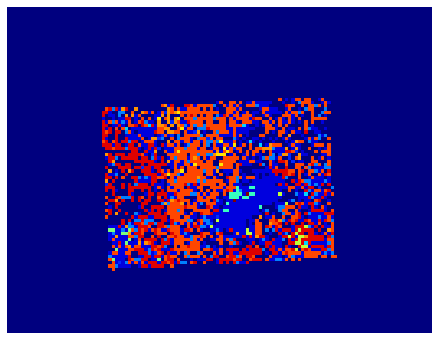

In [7]:
#%%https://stackoverflow.com/questions/67761919/how-to-apply-a-lookup-to-a-label-image-with-more-than-256-labels
#https://realpython.com/iterate-through-dictionary-python/
# Create empty label array
labelArray = np.zeros_like(Labelled_data_roi)
labelsToSpecies = {}
# Create labels
# label = 1
# for species in speciesToID:
#     for value in speciesToID[species]:
#         indices = np.where(Labelled_data_roi == value)
#         labelArray[indices] = label
#         if label not in labelsToSpecies:
#             labelsToSpecies[label] = [species]
#     label += 1

label = 1
for species in speciesToID:
    for value in speciesToID[species]:
        # Find all locations where the value exists in the imgArray
        indices = np.where(Labelled_data_roi == value)
        labelArray[indices] = label
        if label not in labelsToSpecies:
            labelsToSpecies[label] = [species]
    label += 1  if len(indices[0]) > 0 and all(Labelled_data_roi[indices] == value) else 0

print(labelArray)

sns.axes_style('whitegrid')
fig = plt.figure(figsize=(12, 6))

#q = np.random.randint(data.shape[2])
q=7
plt.imshow(labelArray, cmap='jet')
#plt.colorbar()
plt.axis('off')
#plt.title('Ground Truth')

#print(labelsToSpecies)
labelsToSpecies_original=labelsToSpecies

# Convert labelArray elements to integers
labelArray = labelArray.astype(int)

# Count the number of samples for each class
class_counts = np.bincount(labelArray.flatten())

# Find the classes with less than two samples
classes_to_replace = np.where(class_counts < 2)[0]

# Replace the class labels with zero
for cls in classes_to_replace:
    labelArray[labelArray == cls] = 0

for key in classes_to_replace:
    labelsToSpecies.pop(key, None)
    
print(labelsToSpecies)

In [8]:
#%% Extracting pixels using ROI of the HSI
#from untitled0-copy.py... F:\Codes from Other Projects\HSI Image classification Code Practice
X=roi
#y=Labelled_data_roi #ROI of the ground truth image
y=labelArray #modified labelled ground truth data
import pandas as pd
def extract_pixels(X, y,save_name):
  q = X.reshape(-1, X.shape[2]) #z.reshape(-1):It simply means that it is an unknown dimension and we want numpy to figure it out
  image_nan_removed=np.where(np.isnan(q), 0, q)
  df = pd.DataFrame(data = image_nan_removed)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1) #axis 1=column
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  #df.to_csv(f'{save_name}.csv', index=False)
  return df
  
#I have 341504 rows and 224 column in the df  
df = extract_pixels(X, y,save_name='hvd1')
df.head()
#[:, :] literally means [all rows, all columns]
#Indexing in python starts from 0 when you go from the first element to the last, but it starts from -1 when you start from the last element.
#So, when you do [:, -1] it means you are taking all the rows and only the last column. -1 represents the last column
#When you do [:, :-1], it means you are taking all the rows and all the columns except the last column.
df.iloc[:, :-1].describe()
null_sum=df.isnull().sum()

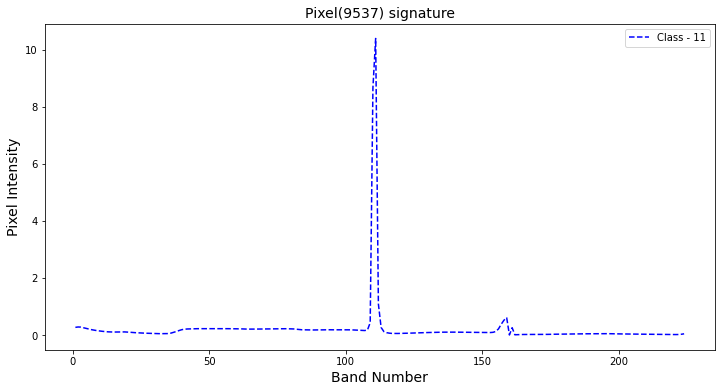

In [9]:
#%% Visualizing spectral signature
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 225), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()
    
plot_signature(df)   
    
 

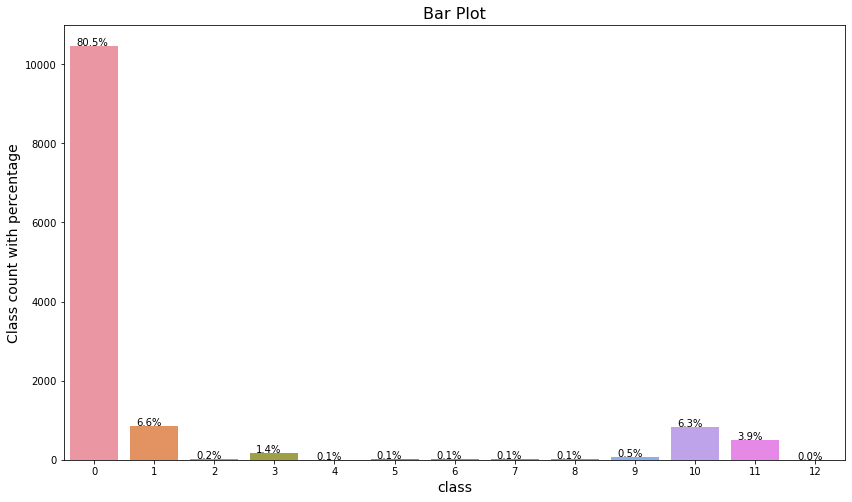

In [10]:
#%%
#https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
plt.figure(figsize=(14, 8))
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picke
ax = sns.countplot(x='class', data=df[['class']])

  # Iterating over the bars one-by-one
  # passing the coordinates where the annotation shall be done
  # x-coordinate: p.get_x() + p.get_width() / 2
  # y-coordinate: p.get_height()
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.1, p.get_height()+5))

plt.ylabel('Class count with percentage', fontsize=14)
plt.xlabel('class', fontsize=14)
plt.title('Bar Plot', fontsize=16)
plt.show()


Enter the band Number(1-224) :12


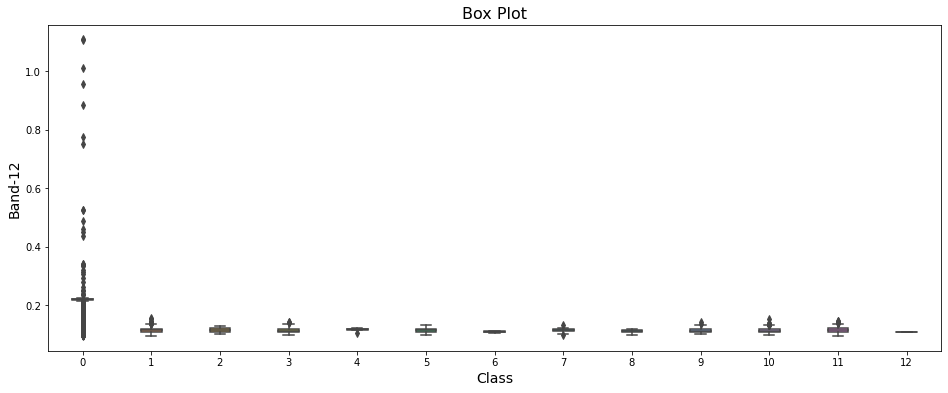

In [11]:
#%% Box plot w.r.t bands of the HSI


plt.figure(figsize=(16, 6))
n = int(input('Enter the band Number(1-224) :'))
sns.boxplot( x=df["class"], y=df[f"band{n}"], width=0.3);
plt.title('Box Plot', fontsize= 16)
plt.xlabel('Class', fontsize= 14)
plt.ylabel(f'Band-{n}', fontsize= 14)
plt.show()


In [ ]:

#%% 6. Distribution Plot
print(f"Details of Band-{n}: \n\n{df['band'+str(n)].describe()}")
plt.figure(figsize=(16, 6))
sns.distplot(df['band'+str(n)], color='mediumSpringGreen', bins=100, hist_kws={'alpha': 0.4});
plt.xlabel('Band - '+str(n), fontsize=14)
plt.title('Disrtibution Plot of Band - '+str(n), fontsize=16)
plt.show()

#give band 8

In [12]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X.shape, y.shape


((13000, 224), (13000,))

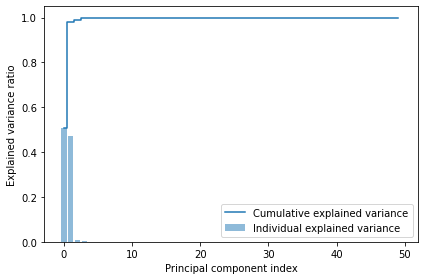

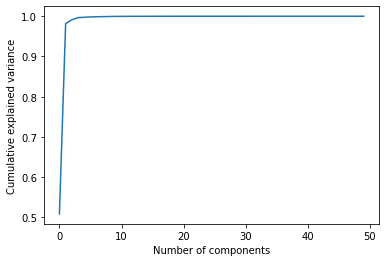

In [13]:
#%% #Implementing PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# %
newX=StandardScaler().fit_transform(X)
pca = PCA(n_components = 50)
principalComponents = pca.fit_transform(newX)
ev=pca.explained_variance_ratio_
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(ev)

# Create the visualization plot
plt.bar(range(0,len(ev)), ev, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


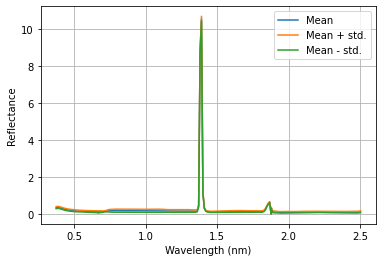

In [14]:
#%%  From Amir's
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X.shape, y.shape

# TODO: calculate average spectra using np.mean and save it as X_mean
# TODO: perform averaging on the first dimension by putting axis argument equal to 0.
wl_cols =df.iloc[:, :-1]
X_mean = wl_cols.mean(axis= 0).to_numpy()
X_mean = X_mean.squeeze()

# TODO: calculate std using np.std, set axis = 0 as well.
X_std =wl_cols.std(axis= 0).to_numpy()
X_std = X_std.squeeze()

# TODO: Input your Y-axis infromation in the empty block based on the label given
plt.figure(0)
plt.plot(wl,X_mean , label = "Mean")
plt.plot(wl,X_mean+X_std , label = "Mean + std.")
plt.plot(wl,X_mean-X_std , label = "Mean - std.")
plt.legend()
plt.ylabel("Reflectance")
plt.xlabel("Wavelength (nm)")
plt.grid(True)

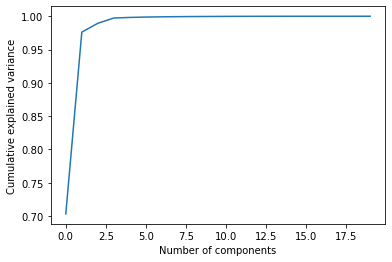

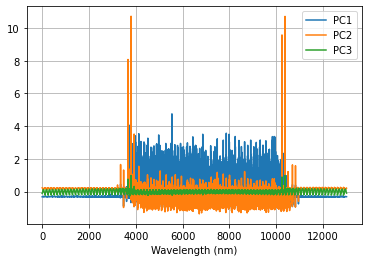

In [16]:
#%%  From Amir's
X_centered =df.iloc[:, :-1]-X_mean
#print(X_centered)

# Now we can perform PCA on X_centered. Call fit_transform on the X_centered.
from sklearn.decomposition import PCA
#pca = PCA()
pca = PCA(n_components = 20)

# TODO: cal fit_transform on X_centered here
pcs = pca.fit_transform(X_centered)
ev=pca.explained_variance_ratio_
# 

plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()



# TODO: complete below
#Plot the first, second, and third pcs below, what does it show?
pc_1 = pcs[:,0]
pc_2 =pcs[:,1]
pc_3 =pcs[:,2]

# TODO: Input your Y-axis infromation in the empty block based on the label given
plt.figure(1)
plt.plot(pc_1 , label = "PC1")
plt.plot(pc_2, label = "PC2")
plt.plot(pc_3 , label = "PC3")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.grid(True)

Text(0.5, 0, 'Wavelength (nm)')

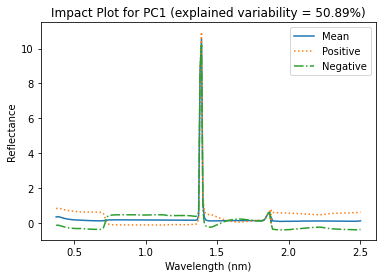

In [17]:
#%%  From Amir's
from sklearn.preprocessing import StandardScaler
def pca_impact(x):
    pca = PCA()
    pca.fit(StandardScaler().fit_transform(x))

    eig_vec = pca.components_
    var_ratio = pca.explained_variance_ratio_
    eig_val = pca.explained_variance_

    return eig_vec, var_ratio, eig_val

eig_vec, var_ratio, eig_val = pca_impact(X)
#eig_vec=epsilon , eig_val=lambda
# TODO: calcualte impact_pos and impact_neg with k = 7 for PC1
# remember that in Python indices start at 0
# apply pc_index on the first dimensions of eig_vals and second dimension of eig_vecs.
pc_index =0
k =0.5
impact_pc1_pos =X_mean+k*eig_val[pc_index]**0.5*eig_vec[pc_index]
impact_pc1_neg =X_mean-k*eig_val[pc_index]**0.5*eig_vec[pc_index]

# here we just show the impact on PC1
plt.figure(2)
plt.plot(wl, X_mean , label = "Mean")
plt.plot(wl, impact_pc1_pos, linestyle = ":",label = "Positive")
plt.plot(wl, impact_pc1_neg, linestyle = "-.",label = "Negative")
plt.legend()
plt.title(r"Impact Plot for PC{} (explained variability = {:.2%})".format(pc_index+1,var_ratio[pc_index]))
plt.ylabel("Reflectance")
plt.xlabel("Wavelength (nm)")

#random_state : int,by default None. Controls how the data is shuffled before the split is implemented. For repeatable output across several function calls, pass an int.

Text(0.5, 0, 'Wavelength (nm)')

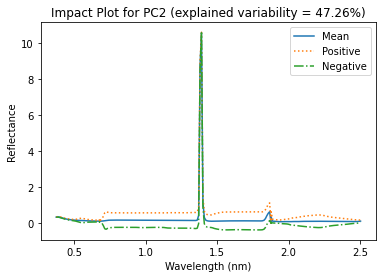

In [18]:
pc_index =1
k =0.5
impact_pc1_pos =X_mean+k*eig_val[pc_index]**0.5*eig_vec[pc_index]
impact_pc1_neg =X_mean-k*eig_val[pc_index]**0.5*eig_vec[pc_index]

# here we just show the impact on PC1
plt.figure(2)
plt.plot(wl, X_mean , label = "Mean")
plt.plot(wl, impact_pc1_pos, linestyle = ":",label = "Positive")
plt.plot(wl, impact_pc1_neg, linestyle = "-.",label = "Negative")
plt.legend()
plt.title(r"Impact Plot for PC{} (explained variability = {:.2%})".format(pc_index+1,var_ratio[pc_index]))
plt.ylabel("Reflectance")
plt.xlabel("Wavelength (nm)")

Text(0.5, 0, 'Wavelength (nm)')

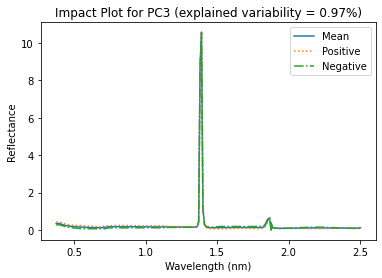

In [19]:
pc_index =2
k =0.5
impact_pc1_pos =X_mean+k*eig_val[pc_index]**0.5*eig_vec[pc_index]
impact_pc1_neg =X_mean-k*eig_val[pc_index]**0.5*eig_vec[pc_index]

# here we just show the impact on PC1
plt.figure(2)
plt.plot(wl, X_mean , label = "Mean")
plt.plot(wl, impact_pc1_pos, linestyle = ":",label = "Positive")
plt.plot(wl, impact_pc1_neg, linestyle = "-.",label = "Negative")
plt.legend()
plt.title(r"Impact Plot for PC{} (explained variability = {:.2%})".format(pc_index+1,var_ratio[pc_index]))
plt.ylabel("Reflectance")
plt.xlabel("Wavelength (nm)")

Text(0.5, 0, 'Wavelength (nm)')

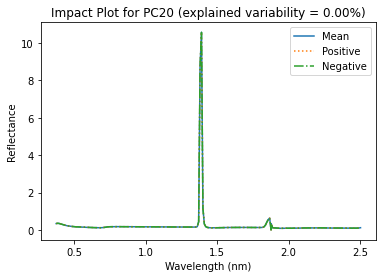

In [20]:
pc_index =19
k =0.5
impact_pc1_pos =X_mean+k*eig_val[pc_index]**0.5*eig_vec[pc_index]
impact_pc1_neg =X_mean-k*eig_val[pc_index]**0.5*eig_vec[pc_index]

# here we just show the impact on PC1
plt.figure(2)
plt.plot(wl, X_mean , label = "Mean")
plt.plot(wl, impact_pc1_pos, linestyle = ":",label = "Positive")
plt.plot(wl, impact_pc1_neg, linestyle = "-.",label = "Negative")
plt.legend()
plt.title(r"Impact Plot for PC{} (explained variability = {:.2%})".format(pc_index+1,var_ratio[pc_index]))
plt.ylabel("Reflectance")
plt.xlabel("Wavelength (nm)")

In [21]:
pcs.shape, range(X.shape[0]), y.shape

((13000, 20), range(0, 13000), (13000,))

In [22]:

def extract_pixels(X, y):
  df = pd.DataFrame(data = X)
  df = pd.concat([df, pd.DataFrame(data = y)], axis=1) #axis 1=column
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[1])]+['class']
  return df
  
df1 = extract_pixels(pcs, y)
#df1.head() #df1.iloc[:, :-1].describe()

df2 = df1[df1['class']!=0]
ind = ['band'+str(i) for i in range(1, df2.shape[-1])]
X_pcs = df2.loc[:, ind]
y=df2.loc[:,'class']
X_pcs.shape, y.shape

((2529, 20), (2529,))

In [22]:
range(1, df2.shape[-1])

range(1, 21)

In [23]:
#%%
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

#Dividing the reduced data into train and test
X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X_pcs, y,  range(X_pcs.shape[0]), 
                                                                                  test_size = 0.30, random_state = 11)
X_train.shape, X_test.shape,y_train.shape, y_test.shape


((1770, 20), (759, 20), (1770,), (759,))

In [24]:
#%% Implementing support vector machine (SVM)
#The support vector machine(SVM) is implemented using Radial Basis Function(RBF) kernel.

svm = SVC(kernel='rbf', degree = 10, gamma='scale', cache_size=1024*7)
svm.fit(X_train, y_train)
  
y_pred = svm.predict(X_test)

from sklearn.metrics import accuracy_score
print(f'Accuracy: {100*accuracy_score(y_test, y_pred)}%')




Accuracy: 55.33596837944664%


In [25]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {100*accuracy_score(y_test, y_pred)}%')

Accuracy: 55.33596837944664%


In [26]:
from sklearn.metrics import cohen_kappa_score
print("Cohen Kappa Score :",cohen_kappa_score(y_pred, y_test)*100)



Cohen Kappa Score : 35.965466780815106


In [27]:
from sklearn.metrics import  f1_score
print("f1_score:",(f1_score(y_test, y_pred, average='micro')))

f1_score: 0.5533596837944664


In [28]:
print(labelsToSpecies)

{1: ['acer'], 2: ['aronme'], 3: ['betu'], 4: ['fraxni'], 5: ['hamavi'], 6: ['kalmla'], 7: ['larila'], 8: ['ostrvi'], 9: ['pinu'], 10: ['quer'], 11: ['rhodpr'], 12: ['ulmuam']}


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           1       0.50      0.63      0.56       261
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        27
          10       0.58      0.64      0.61       238
          11       0.63      0.68      0.65       154
          12       0.00      0.00      0.00         1

    accuracy                           0.55       759
   macro avg       0.14      0.16      0.15       759
weighted avg       0.48      0.55      0.51       759



C:\Users\Manis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(labelsToSpecies)

{1: ['acer'], 2: ['aronme'], 3: ['betu'], 4: ['fraxni'], 5: ['hamavi'], 6: ['kalmla'], 7: ['larila'], 8: ['ostrvi'], 9: ['pinu'], 10: ['quer'], 11: ['rhodpr'], 12: ['ulmuam']}


In [31]:
# Classification Report
target_names = ['1: acer', '2: aronme', '3: betu',
                '4: fraxni', '5: hamavi', '6: kalmla', '7: larila',
                 '8: ostrvi', '9: pinu','10: quer', '11: rhodpr',
                '12: ulmuam'
               ]

print(classification_report(y_test, y_pred,target_names=target_names))


              precision    recall  f1-score   support

     1: acer       0.50      0.63      0.56       261
   2: aronme       0.00      0.00      0.00         6
     3: betu       0.00      0.00      0.00        53
   4: fraxni       0.00      0.00      0.00         3
   5: hamavi       0.00      0.00      0.00         3
   6: kalmla       0.00      0.00      0.00         4
   7: larila       0.00      0.00      0.00         3
   8: ostrvi       0.00      0.00      0.00         6
     9: pinu       0.00      0.00      0.00        27
    10: quer       0.58      0.64      0.61       238
  11: rhodpr       0.63      0.68      0.65       154
  12: ulmuam       0.00      0.00      0.00         1

    accuracy                           0.55       759
   macro avg       0.14      0.16      0.15       759
weighted avg       0.48      0.55      0.51       759



C:\Users\Manis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-32-a0fdc7909e2e>:12: RuntimeWarning: invalid value encountered in divide
  cmn = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]


{'hamavi', 'larila', 'fraxni', 'ostrvi', 'ulmuam', 'betu', 'aronme', 'kalmla', 'pinu'}


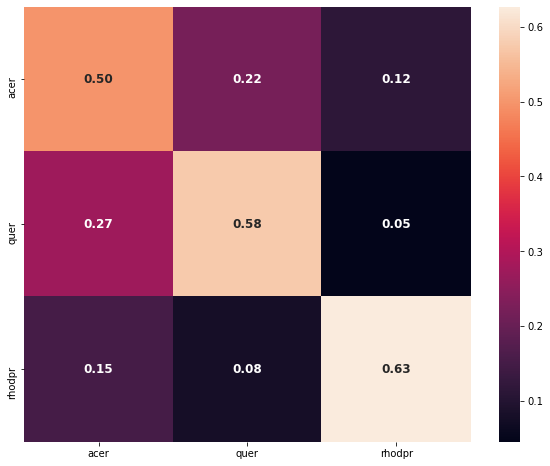

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,8))
classes = ['acer', 'aronme', 'betu',
            'fraxni', 'hamavi', 'kalmla', 'larila',
            'ostrvi', 'pinu','quer', 'rhodpr',
            'ulmuam'
          ]

mat = confusion_matrix(y_pred, y_test)
# Normalise
cmn = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cmn, index = classes, columns = classes)

# # Default drop rows that contains nan values
df2=df_cm.dropna()
#print(df2)

#print(df2.columns.tolist())
# Get the list of index names
index_names = df2.index.tolist()
# Get the list of column names
column_names = df2.columns.tolist()
# Find the set intersection of the two lists
# unique_names = set(index_names).intersection(column_names)
# # Print the unique names
# print(unique_names)
# find the set difference between the two lists
names_diff = set(column_names)-set(index_names)

# print the result
print(names_diff)
df2=df2.drop(columns=names_diff)

#sns.set(font_scale=1.2)
#sns.heatmap(df2, annot=True, fmt='.2f')
sns.heatmap(df2, annot=True, annot_kws={"size":12, "weight": "bold"},fmt='.2f')

plt.show()